<a href="https://colab.research.google.com/github/aasyngier/machine-learning/blob/main/ml_homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Optimizing the Classification Threshold in Logistic Regression**

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)

First let's prepare the data we'll be working with by loading the breast cancer dataset, dividing it into three parts: train, validation, test and standardizing the features.

In [31]:
data = load_breast_cancer()
print(data.DESCR)
X = data.data
y = data.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4,
                                                    random_state=90, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

We now train a Logistic Regression model on our training set:

In [32]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000)

Using the validation set we will: plot the ROC curve and calculate the AUC. We determine the optimal threshold using using Youden's Index (maximizing sensitivity - FPR).

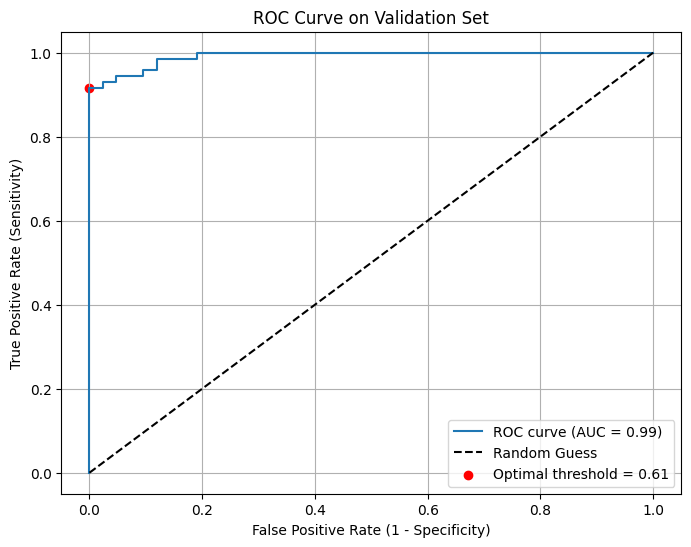

In [35]:
y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
auc_val = roc_auc_score(y_val, y_val_proba)

youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red',
            label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

Lastly, let's apply the selected threshold to the test set to evaluate final model performance using metrics like: Accuracy, Precision & Recall, F1-Score, Specificity & Sensitivity.

In [36]:
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
recall_val = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
specificity = tn / (tn + fp)

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Test Accuracy: {acc:.2f}")
print(f"Test Precision: {prec:.2f}")
print(f"Test Recall (Sensitivity): {recall_val:.2f}")
print(f"Test Specificity: {specificity:.2f}")
print(f"Test F1 Score: {f1:.2f}")

Optimal threshold: 0.61
Test Accuracy: 0.98
Test Precision: 0.99
Test Recall (Sensitivity): 0.99
Test Specificity: 0.98
Test F1 Score: 0.99


Based on the analysis of our dataset we can now answer the following questions:

1. **Would a different threshold yield better results?**  
   - How does shifting the threshold affect the **trade-off between sensitivity and specificity**?

   Adjusting the threshold changes the balance between:

  - Sensitivity (True Positive Rate): The proportion of actual positives correctly identified.
  - Specificity (True Negative Rate): The proportion of actual negatives correctly identified.


2. **How do you define "better" results?**  
   - Is **higher specificity** more valuable than **higher sensitivity** in certain contexts? Or maybe the other way around?
   - Does the **best threshold** depend on the task? (discuss cases like *disease detection* vs. *spam filtering*)

  How we define better results mostly depends on the context and the dataset we're examining. For example, in disease detection (so just like in our case of breast cancer), missing a false negative can be critical. Lowering the threshold might increase sensitivity (catching more true cases) even though it could decrease specificity.

  On the other hand, consider spam filtering. In spam detection, marking a legitimate email as spam (a false positive) can cause users to miss important communications. Here, higher specificity might be more valuable because you want to minimize the chance of misclassifying valid emails as spam.

3. **How does a ROC curve help in this process?**  
   - Learn how to use a **ROC curve** to visualize the trade-off between **True Positive Rate (Sensitivity)** and **False Positive Rate (1 - Specificity)**.

  A ROC curve is a valuable tool because it visualizes the trade-off between the True Positive Rate (Sensitivity) and the False Positive Rate (1 - Specificity) across all possible classification thresholds. Each point on the ROC curve represents a different threshold, making it easier to compare how adjustments to the threshold impact both sensitivity and specificity and thus to pick our optimal threshold for the given task.



4. **How do you select the optimal threshold using the ROC curve?**  
   - Discuss strategies to select a threshold depending on the specific task at hand and the acceptable **trade-off between sensitivity and specificity**.

  One common approach is to maximize Youden’s index (sensitivity – false positive rate). This metric identifies the threshold that provides the best balance between sensitivity and specificity. In our notebook, the threshold corresponding to the maximum Youden’s index was chosen as the optimal threshold.

  Instead of Youden’s index, you could maximize the F1‐score, Precision, or any other metric depending on the problem. You would calculate the chosen metric for a range of potential thresholds and select the cutoff that yields the best trade‐off for that metric.
  
  Another approach would be to ensure at least a certain level of sensitivity  or specificity. You can, for example, pick the highest threshold that yields at least 90% sensitivity, or at least 95% specificity.


5. **What is the AUC metric and how is it useful?**  
   - Define **AUC (Area Under the Curve)** and discuss its role in evaluating the overall performance of a classifier.

  The Area Under the Curve quantifies the overall ability of the model to discriminate between the two classes. An AUC of 1.0 represents perfect discrimination, whereas an AUC of 0.5 suggests no discrimination (similar to random guessing). The AUC is valuable because it summarizes the model’s performance across all possible thresholds.

**To summarize let's answer the main question: Is a 0.5 threshold always the best choice in Logistic Regression?**

In our experiment, the ROC analysis on the validation set suggested an optimal threshold (using Youden’s index) that may differ from 0.5. This indicates that while 0.5 is the common default, it is not necessarily optimal for every problem. The best threshold depends on how we want to weigh sensitivity versus specificity for our particular task.